In [5]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip

--2024-06-01 13:39:17--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.166.56, 52.217.128.80, 52.217.229.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.166.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247694507 (236M) [application/zip]
Saving to: ‘processed-celeba-small.zip’

processed-celeba-sm 100%[===================>] 236.22M  43.7MB/s    in 6.0s    

2024-06-01 13:39:23 (39.7 MB/s) - ‘processed-celeba-small.zip’ saved [247694507/247694507]



In [6]:
import os

data_dir = 'processed-celeba-small/'

if not os.path.isdir(data_dir):
    !unzip processed-celeba-small.zip
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  

In [7]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [8]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):

    dataset = datasets.ImageFolder(data_dir, transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ]))

    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [9]:
batch_size = 32
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

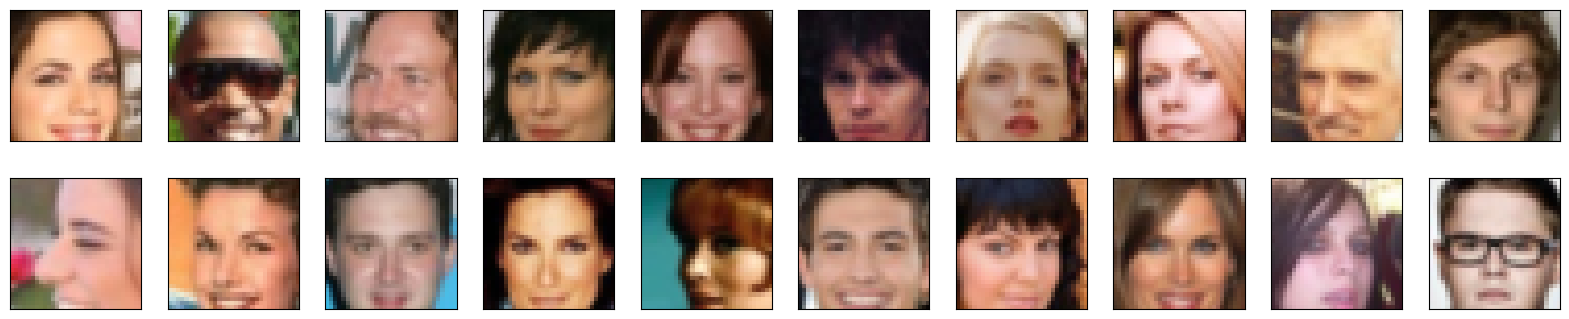

In [10]:
def imshow(img): #zmodyfikowana funkcja, znaleziona z innych programów do plotowania ilustracji
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = next(dataiter) # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [11]:
def scale(x, feature_range=(-1, 1)):
    "skalowanie obrazów w celu użycia funkcji aktywacyjnej tanh"
    rmin, rmax = feature_range
    return rmin + (rmax-rmin) * x

In [12]:
img = images[0]
scaled_img = scale(img)

print(f'Przed: [{img.min():.4f}, {img.max():.4f}]')
print(f'Po: [{scaled_img.min():.4f}, {scaled_img.max():.4f}]')

Before scaling: [0.0196, 1.0000]
After scaling: [-0.9608, 1.0000]


In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
def conv(in_channels, out_channels, kernel_size, padding, stride=2, batch_norm=True):
    "block kownolucyjny"
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim, kernel_size=7, padding=3):

        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        "bloki konwolucyjne"
        self.conv1 = conv(3, conv_dim, batch_norm=False, kernel_size=kernel_size, padding=padding)
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=kernel_size, padding=padding)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=kernel_size, padding=padding)
        "warstwa w pełni łączona"
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        return x

In [16]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):

    """blok dekonwolucyjny z transponowana konwolucja"""
    layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [120]:
def deconv2(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, upsample=True):

    """blok dekonwolucyjny z upsamplingiem zamiast transponowana konwolucja"""

    layers = []
    layers.append(nn.Upsample(scale_factor=4, mode='nearest'))
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))


    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [121]:
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, 4*4*conv_dim*4)
        self.tconv1 = deconv(conv_dim*4, conv_dim*2)
        self.tconv2 = deconv(conv_dim*2, conv_dim)
        self.tconv3 = deconv(conv_dim, 3, batch_norm=False)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        # print(x.size())
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.tanh(self.tconv3(x))
        print(x.size())

        return x

In [126]:
class Generator2(nn.Module):

    def __init__(self, z_size, conv_dim):
        super(Generator2, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, 4*4*conv_dim*4)
        self.tconv1 = deconv2(conv_dim*4, conv_dim*2)
        self.tconv2 = deconv2(conv_dim*2, conv_dim)
        self.tconv3 = deconv2(conv_dim, 3, batch_norm=False)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        #print(x.size())
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.tanh(self.tconv3(x))
        #print(x.size())

        return x

In [86]:
from torch.nn import init

def weights_init_normal(layer, mean=0, sd=0.02):

    eligible = [nn.ConvTranspose2d, nn.Conv2d, nn.Linear]

    if type(layer) in eligible:
        print(f'Inicjalizacja wag {layer}')
        init.normal_(layer.weight.data, mean, sd)

In [87]:
def build_network(d_conv_dim, g_conv_dim, z_size, d_kernel_size, d_padding):

    D = Discriminator(d_conv_dim, d_kernel_size, d_padding)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)

    return D, G

In [88]:
d_conv_dim = 64
g_conv_dim = 128
z_size = 200 #długość wektora poczatkowego dla generatora
d_kernel_size = 7 #3x3 wypróbować
d_padding = 3

D, G = build_network(d_conv_dim, g_conv_dim, z_size, d_kernel_size, d_padding)

Inicjalizacja wag Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Inicjalizacja wag Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Inicjalizacja wag Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Inicjalizacja wag Linear(in_features=4096, out_features=1, bias=True)
Inicjalizacja wag Linear(in_features=200, out_features=8192, bias=True)
Inicjalizacja wag ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
Inicjalizacja wag ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
Inicjalizacja wag ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): B

In [89]:
import torch

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [24]:
def real_loss(D_out): #funkcja zaczerpnięta z poradnika
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(D_out.squeeze(), labels)

def fake_loss(D_out):  #funkcja zaczerpnięta z poradnika
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(D_out.squeeze(), labels)

In [25]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [27]:
def forward_loss(net, images, loss_fcn):
    if train_on_gpu:
        images = images.cuda()
    result = net(images)
    return loss_fcn(result)

def create_fake_images(generator, batch_size, z_size):
    image_seeds = np.random.uniform(-1, 1, size=(batch_size, z_size))
    image_seeds = torch.from_numpy(image_seeds).float()
    if train_on_gpu:
        image_seeds = image_seeds.cuda()
    return generator.forward(image_seeds)

In [28]:
def train(D, G, n_epochs, print_every=50, train_samples_filepath='train_samples.pkl'):

    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            d_real_loss = forward_loss(D, real_images, real_loss)
            fake_images = create_fake_images(G, batch_size, z_size)
            d_fake_loss = forward_loss(D, fake_images, fake_loss)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            fake_images = create_fake_images(G, batch_size, z_size)
            g_loss = forward_loss(D, fake_images, real_loss)
            g_loss.backward()
            g_optimizer.step()


            if batch_i % print_every == 0:

                losses.append((d_loss.item(), g_loss.item()))
                d_loss_item = d_loss.item()
                g_loss_item = g_loss.item()
                summed_loss = d_loss_item + g_loss_item
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | summed_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss_item, g_loss_item, summed_loss))

        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open(train_samples_filepath, 'wb') as f:
        pkl.dump(samples, f)


    return losses

In [32]:
n_epochs = 20
test_nb = 4
train_samples_filepath = f'train_samples_{test_nb:02d}.pkl'

import os
while os.path.exists(train_samples_filepath):
    test_nb += 1
    train_samples_filepath = f'train_samples_{test_nb:02d}.pkl'

loss_plot_filepath = f'loss_plot_{test_nb:02d}.png'
print(f'Samples generated during training will be saved in {train_samples_filepath} file.')

with open('tests.txt', 'a') as test_summary_file:
    test_summary_file.write(f'Test nb: {test_nb}, N_epochs: {n_epochs}, LR: {lr}, Beta1: {beta1}, Beta2: {beta2}, '\
                            f' d_conv_dim: {d_conv_dim}, g_conv_dim: {g_conv_dim}, z_size: {z_size}')


losses = train(D, G, n_epochs=n_epochs, train_samples_filepath=train_samples_filepath)

Samples generated during training will be saved in train_samples_04.pkl file.
Epoch [    1/   20] | d_loss: 1.0474 | g_loss: 1.0715 | summed_loss: 2.1189
Epoch [    1/   20] | d_loss: 1.1435 | g_loss: 1.3894 | summed_loss: 2.5329
Epoch [    1/   20] | d_loss: 1.2583 | g_loss: 1.1878 | summed_loss: 2.4461
Epoch [    1/   20] | d_loss: 1.0650 | g_loss: 1.1903 | summed_loss: 2.2553
Epoch [    1/   20] | d_loss: 0.9862 | g_loss: 1.4722 | summed_loss: 2.4585
Epoch [    1/   20] | d_loss: 0.9764 | g_loss: 0.8464 | summed_loss: 1.8228
Epoch [    1/   20] | d_loss: 1.1451 | g_loss: 1.8801 | summed_loss: 3.0252
Epoch [    1/   20] | d_loss: 1.0602 | g_loss: 1.5980 | summed_loss: 2.6582
Epoch [    1/   20] | d_loss: 1.4662 | g_loss: 0.9634 | summed_loss: 2.4296
Epoch [    1/   20] | d_loss: 0.9596 | g_loss: 1.5005 | summed_loss: 2.4601
Epoch [    1/   20] | d_loss: 1.2835 | g_loss: 0.7000 | summed_loss: 1.9835
Epoch [    1/   20] | d_loss: 1.3102 | g_loss: 0.7468 | summed_loss: 2.0570
Epoch [   

In [33]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [35]:
with open('train_samples_04.pkl', 'rb') as f:
    samples = pkl.load(f)

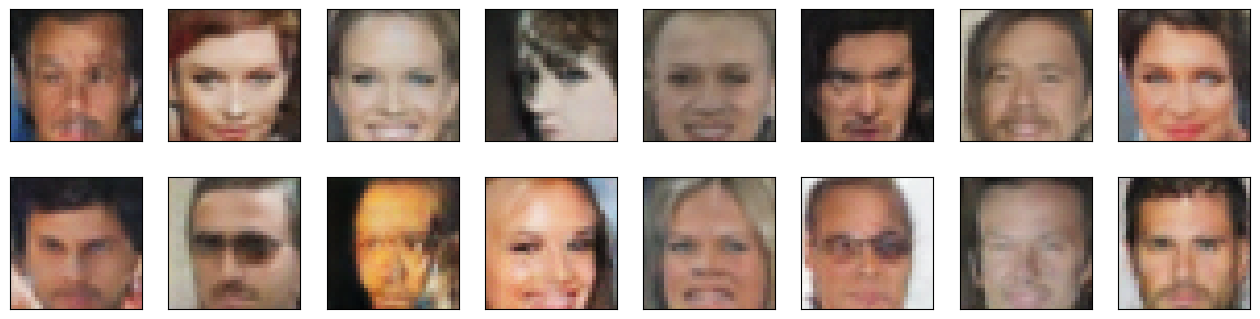

In [36]:
_ = view_samples(-1, samples)

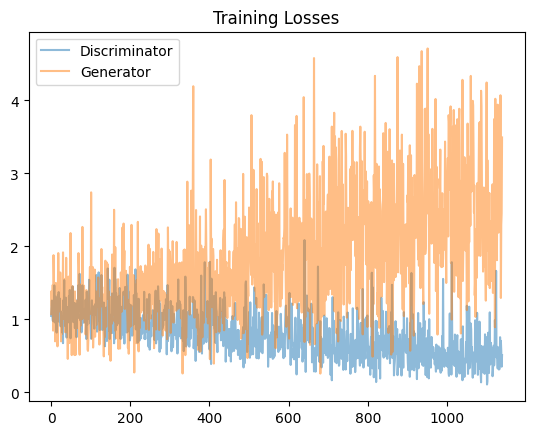

In [37]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [131]:
def build_network2(d_conv_dim, g_conv_dim, z_size, d_kernel_size, d_padding):

    D2 = Discriminator(d_conv_dim, d_kernel_size, d_padding)
    G2 = Generator2(z_size=z_size, conv_dim=g_conv_dim)

    D2.apply(weights_init_normal)
    G2.apply(weights_init_normal)

    print(D2)
    print()
    print(G2)

    return D2, G2

In [132]:
D2, G2 = build_network2(d_conv_dim, g_conv_dim, z_size, d_kernel_size, d_padding)

d2_optimizer = optim.Adam(D2.parameters(), lr, [beta1, beta2])
g2_optimizer = optim.Adam(G2.parameters(), lr, [beta1, beta2])

Inicjalizacja wag Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Inicjalizacja wag Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Inicjalizacja wag Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Inicjalizacja wag Linear(in_features=4096, out_features=1, bias=True)
Inicjalizacja wag Linear(in_features=200, out_features=8192, bias=True)
Inicjalizacja wag Conv2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
Inicjalizacja wag Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
Inicjalizacja wag Conv2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, 

In [136]:
def train2(D, G, n_epochs, print_every=50, train_samples_filepath='train_samples.pkl'):

    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d2_optimizer.zero_grad()
            d2_real_loss = forward_loss(D, real_images, real_loss)
            fake_images = create_fake_images(G, batch_size, z_size)
            d2_fake_loss = forward_loss(D, fake_images, fake_loss)
            d2_loss = d2_real_loss + d2_fake_loss
            d2_loss.backward()
            d2_optimizer.step()

            g2_optimizer.zero_grad()
            fake_images = create_fake_images(G, batch_size, z_size)
            g2_loss = forward_loss(D, fake_images, real_loss)
            g2_loss.backward()
            g2_optimizer.step()


            if batch_i % print_every == 0:

                losses.append((d2_loss.item(), g2_loss.item()))
                d2_loss_item = d2_loss.item()
                g2_loss_item = g2_loss.item()
                summed_loss = d2_loss_item + g2_loss_item
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | summed_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d2_loss_item, g2_loss_item, summed_loss))

        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open(train_samples_filepath, 'wb') as f:
        pkl.dump(samples, f)


    return losses

In [ ]:
n_epochs = 20
test_nb = 4
train_samples_filepath2 = f'train_samples2_{test_nb:02d}.pkl'

import os
while os.path.exists(train_samples_filepath):
    test_nb += 1
    train_samples_filepath = f'train_samples2_{test_nb:02d}.pkl'

loss_plot_filepath = f'loss_plot2_{test_nb:02d}.png'
print(f'Samples generated during training will be saved in {train_samples_filepath2} file.')

with open('tests2.txt', 'a') as test_summary_file:
    test_summary_file.write(f'Test nb: {test_nb}, N_epochs: {n_epochs}, LR: {lr}, Beta1: {beta1}, Beta2: {beta2}, '\
                            f' d_conv_dim: {d_conv_dim}, g_conv_dim: {g_conv_dim}, z_size: {z_size}')


losses2 = train2(D2, G2, n_epochs=n_epochs, train_samples_filepath=train_samples_filepath2)

Samples generated during training will be saved in train_samples2_04.pkl file.
Epoch [    1/   20] | d_loss: 0.9202 | g_loss: 3.1156 | summed_loss: 4.0358
Epoch [    1/   20] | d_loss: 1.6444 | g_loss: 4.8683 | summed_loss: 6.5127
Epoch [    1/   20] | d_loss: 1.0818 | g_loss: 2.2694 | summed_loss: 3.3512
Epoch [    1/   20] | d_loss: 2.1191 | g_loss: 0.7649 | summed_loss: 2.8840
Epoch [    1/   20] | d_loss: 0.5554 | g_loss: 3.2255 | summed_loss: 3.7810
Epoch [    1/   20] | d_loss: 0.7130 | g_loss: 3.2494 | summed_loss: 3.9624
Epoch [    1/   20] | d_loss: 1.0272 | g_loss: 1.7404 | summed_loss: 2.7676
Epoch [    1/   20] | d_loss: 1.0656 | g_loss: 1.3390 | summed_loss: 2.4046
Epoch [    1/   20] | d_loss: 1.2968 | g_loss: 0.9605 | summed_loss: 2.2573
Epoch [    1/   20] | d_loss: 1.5702 | g_loss: 2.1113 | summed_loss: 3.6815
Epoch [    1/   20] | d_loss: 0.9460 | g_loss: 1.3084 | summed_loss: 2.2544
Epoch [    1/   20] | d_loss: 1.0173 | g_loss: 1.6416 | summed_loss: 2.6589
Epoch [  